In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from core.model import Model

import json

In [2]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [3]:
df = pd.read_csv('./data/sinewave.csv')  # 读取股票文件

In [4]:
df.head()

,sinewave
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


In [5]:
# 获取DataFrame中的数据，形式为数组array形式
values = df.values
# 确保所有数据为float类型
values = values.astype('float32')

# 特征的归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(scaled)

[[0.92074144]
 [0.93687433]
 [0.9512831 ]
 ...
 [0.88356435]
 [0.902948  ]
 [0.92074144]]


In [6]:
# 定义series_to_supervised()函数
# 将时间序列转换为监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    将时间序列框定为有监督的学习数据集。
        论据：
        数据：作为列表或NumPy数组的观察序列。
        n_in：作为输入的滞后观测数（X）。
        n_out：作为输出的观察数（y）。
        dropnan：布尔值，决定是否删除具有NaN值的行。
    返回：
    pd.DataFrame(用于监督学习)
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
# 将时间序列转换为监督学习问题
reframed = series_to_supervised(scaled, 1, 1)

In [8]:
reframed.head()

,var1(t-1),var1(t)
1,0.920741,0.936874
2,0.936874,0.951283
3,0.951283,0.963911
4,0.963911,0.974708
5,0.974708,0.983631


In [9]:
# 划分训练集和测试集
train = reframed.iloc[:int(len(reframed) * 0.85), :].values
test = reframed.iloc[int(len(reframed) * 0.85):, :].values
# 划分训练集和测试集的输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 转化为三维数据
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [10]:
configs = json.load(open('./test_2/config.json', 'r'))

In [11]:
model = Model()
model.build_model(configs, train_X.shape[1], train_X.shape[2])

[Model] Model Compiled
Time taken: 0:00:01.364231


In [12]:
# 内存中训练
model.train(
    train_X,
    train_y,
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    validation_data=(test_X, test_y),
    verbose=configs['training']['verbose'],
    shuffle=configs['training']['shuffle'],
    validation_freq=configs['training']['validation_freq'],
    save_dir=configs['model']['save_dir']
)

[Model] Training Started
[Model] 50 epochs, 64 batch size
Epoch 1/50
67/67 [==============================] - 10s 39ms/step - loss: 0.1427 - val_loss: 0.0220
Epoch 2/50
67/67 [==============================] - 1s 14ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 3/50
67/67 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 4/50
67/67 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 5/50
67/67 [==============================] - 1s 14ms/step - loss: 0.0028 - val_loss: 7.6851e-04
Epoch 6/50
67/67 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 5.6910e-04
Epoch 7/50
67/67 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 6.6206e-04
Epoch 8/50
67/67 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 5.2819e-04
Epoch 9/50
67/67 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 5.0650e-04
Epoch 10/50
67/67 [===========

In [13]:
y_predict = model.predict_point_by_point(test_X)

[Model] Predicting Point-by-Point...


In [14]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

### 训练数据跟测试数据都相等的情况

In [15]:
# invert scaling for forecast
# 将预测结果按比例反归一化
inv_y_predict = scaler.inverse_transform(y_predict)

In [16]:
# invert scaling for actual
# 将真实结果按比例反归一化
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = scaler.inverse_transform(test_y)
inv_y = inv_y_train[:, -1]

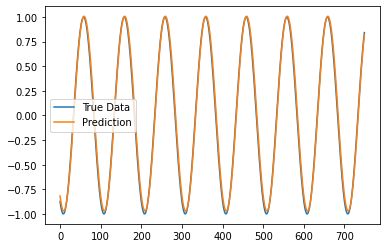

In [17]:
plot_results(inv_y_predict, inv_y)